In [1]:
%%writefile MiniVggnet.py
import tensorflow as tf
#from tf.keras.models import Sequential
#from tf.keras import backend as K

class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = tf.keras.models.Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        if tf.keras.backend.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                         input_shape=inputShape))
        model.add(tf.keras.layers.Activation("relu"))
        model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
        model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same"))
        model.add(tf.keras.layers.Activation("relu"))
        model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))

        model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same"))
        model.add(tf.keras.layers.Activation("relu"))
        model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same"))
        model.add(tf.keras.layers.Activation("relu"))
        model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))

        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(512))
        model.add(tf.keras.layers.Activation("relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.5))

        model.add(tf.keras.layers.Dense(classes))
        model.add(tf.keras.layers.Activation("softmax"))
        # return the constructed network architecture
        return model

Overwriting MiniVggnet.py


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import MiniVggnet

!ls

'A_Z Handwritten Data.csv'   img_dataset.ipynb	 __pycache__
 digit_proj.ipynb	     MiniVggnet.py	 Untitled.ipynb


In [3]:
data=pd.read_csv('A_Z Handwritten Data.csv').astype('float32')
#print(data.head(1))

In [4]:
data.rename(columns={'0': 'label'}, inplace=True)
X = data.drop('label', axis=1)
y = data['label']
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(372450, 784) (372450,)


In [5]:
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
  X_train = X_train.reshape(X_train.shape[0], 1, 28,28)
  X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
  input_shape = (1, 28, 28)
else:
  X_train = X_train.reshape(X_train.shape[0],28, 28, 1)
  X_test = X_test.reshape(X_test.shape[0],28, 28, 1)
  input_shape = (28, 28, 1)

In [7]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, fill_mode="nearest")

In [9]:
print("[INFO] compiling model....")

opt = tf.keras.optimizers.SGD(lr=0.001)
model=MiniVggnet.MiniVGGNet.build(width=28,height=28,depth=1,classes=26)
model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

[INFO] compiling model....


In [11]:
print("[INFO] training network...")

H = model.fit_generator(aug.flow(X_train, y_train, batch_size=32),
validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // 32,
epochs=20, verbose=1)

[INFO] training network...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
7798/7798 [==============================] - 356s 46ms/step - loss: 1.3449 - accuracy: 0.6329 - val_loss: 0.1603 - val_accuracy: 0.9555
Epoch 2/20
7798/7798 [==============================] - 321s 41ms/step - loss: 0.6097 - accuracy: 0.8174 - val_loss: 0.1153 - val_accuracy: 0.9680
Epoch 3/20
7798/7798 [==============================] - 321s 41ms/step - loss: 0.4553 - accuracy: 0.8637 - val_loss: 0.0964 - val_accuracy: 0.9737
Epoch 4/20
7798/7798 [==============================] - 320s 41ms/step - loss: 0.3737 - accuracy: 0.8879 - val_loss: 0.0919 - val_accuracy: 0.9751
Epoch 5/20
7798/7798 [==============================] - 320s 41ms/step - loss: 0.3270 - accuracy: 0.9027 - val_loss: 0.0813 - val_accuracy: 0.9779
Epoch 6/20
7798/7798 [==============================] - 320s 41ms/step - loss: 0.2947 - accuracy: 0.9129 - val_loss: 0.0775 - val_accuracy: 0.9791
Epoch 7/20
7798

In [12]:
from sklearn.metrics import classification_report
target_names=["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
print("[INFO] evaluating network...")
predictions = model.predict(X_test,batch_size=128)
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1),
                            target_names=target_names))

[INFO] evaluating network...
              precision    recall  f1-score   support

           A       0.98      0.99      0.99      4518
           B       0.97      0.99      0.98      2822
           C       0.98      0.99      0.99      7893
           D       0.97      0.92      0.95      3285
           E       0.99      0.99      0.99      3773
           F       0.95      0.99      0.97       367
           G       0.97      0.97      0.97      1881
           H       0.97      0.97      0.97      2363
           I       0.96      0.99      0.98       383
           J       0.98      0.97      0.97      2738
           K       0.97      0.97      0.97      1876
           L       0.99      0.97      0.98      3784
           M       0.98      0.99      0.99      4081
           N       0.99      0.99      0.99      6131
           O       0.99      0.99      0.99     19161
           P       0.99      0.99      0.99      6417
           Q       0.98      0.98      0.98      194

In [13]:
model.save("AlphabetrecognitionModel.hdf5")

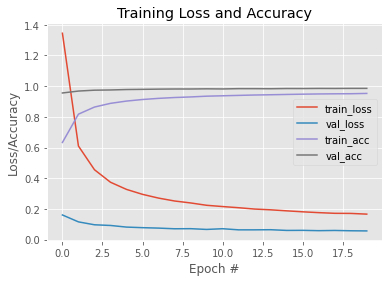

<Figure size 432x288 with 0 Axes>

In [14]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
plt.savefig('AlphabetrecogwithMiniVggnet.png')

In [15]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()